# EDA: COVID Projections for CA Counties

This notebook performs EDA on a dataset of projections for the spread of COVID-19 within California. The data is cleaned up to focus on the changing prevalence of the virus within each county over the next month (May to June). A severity threshold is established whereby the situation in a county is considered to be severe if there is more than one new infection case per 10,000 residents within a single day.

> Dataset: Columbia MSPH COVID-19 Projections (May 10th update) <br>
> Source: https://github.com/shaman-lab/COVID-19Projection <br>
> Units: The 58 CA counties <br>
> Dates: May 10 - June 20

In [1]:
# import libraries

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# read in the MSPH data

msph = pd.read_csv('./Raw_Data/MSPH_5_10_times5weekly.csv')

print(msph.shape)
msph.head()

(131964, 13)


,county,fips,Date,report_2.5,report_25,report_50,report_75,report_97.5,total_2.5,total_25,total_50,total_75,total_97.5
0,Autauga County AL,1001,05/10/20,0,2,3,4,8,16,29,42,51,73
1,Baldwin County AL,1003,05/10/20,1,3,5,6,12,12,26,33,42,57
2,Barbour County AL,1005,05/10/20,0,0,0,0,2,1,2,4,5,8
3,Bibb County AL,1007,05/10/20,0,0,1,1,4,1,4,6,8,17
4,Blount County AL,1009,05/10/20,0,1,1,2,5,0,2,3,7,15


In [3]:
# Extract the rows for California

# Remove rows for all counties outside California
msph = msph.loc[msph['county'].str.endswith('CA')]

# reset the index
msph.reset_index(inplace=True)
msph.drop(columns=['index'], inplace=True)

# Display the results
print(msph.shape)
msph.head()

(2436, 13)


,county,fips,Date,report_2.5,report_25,report_50,report_75,report_97.5,total_2.5,total_25,total_50,total_75,total_97.5
0,Alameda County CA,6001,05/10/20,31,40,46,54,70,130,164,194,233,288
1,Alpine County CA,6003,05/10/20,0,0,0,0,0,0,0,0,0,0
2,Amador County CA,6005,05/10/20,0,0,0,1,3,0,1,3,6,12
3,Butte County CA,6007,05/10/20,0,0,0,1,3,0,1,2,4,10
4,Calaveras County CA,6009,05/10/20,0,0,0,1,3,0,1,2,4,9


In [4]:
# Remove the extraneous words from the county column

msph['county'] = msph['county'].str.replace(' County CA', '')

# Display the results
print(msph.shape)
msph.head()

(2436, 13)


,county,fips,Date,report_2.5,report_25,report_50,report_75,report_97.5,total_2.5,total_25,total_50,total_75,total_97.5
0,Alameda,6001,05/10/20,31,40,46,54,70,130,164,194,233,288
1,Alpine,6003,05/10/20,0,0,0,0,0,0,0,0,0,0
2,Amador,6005,05/10/20,0,0,0,1,3,0,1,3,6,12
3,Butte,6007,05/10/20,0,0,0,1,3,0,1,2,4,10
4,Calaveras,6009,05/10/20,0,0,0,1,3,0,1,2,4,9


In [5]:
# Select the target column: 
# the middle projection for the total number of new daily infections,
# which includes both reported and unreported cases.

msph = msph[['county', 'Date', 'total_50']]

# Adjust the column names
msph.rename(columns={'Date': 'date', 'total_50':'est_new_infections'}, inplace=True)

# Display the results
print(msph.shape)
msph.head()

(2436, 3)


,county,date,est_new_infections
0,Alameda,05/10/20,194
1,Alpine,05/10/20,0
2,Amador,05/10/20,3
3,Butte,05/10/20,2
4,Calaveras,05/10/20,2


In [6]:
# Convert the date column from string to date-time dtype.

msph["date"] = pd.to_datetime(msph['date'])

# Display the results
print(msph.shape)
msph.head()

(2436, 3)


,county,date,est_new_infections
0,Alameda,2020-05-10,194
1,Alpine,2020-05-10,0
2,Amador,2020-05-10,3
3,Butte,2020-05-10,2
4,Calaveras,2020-05-10,2


In [7]:
# Resort the rows by county and then date

msph = msph.sort_values(['county','date'])

# reset the index
msph.reset_index(inplace=True)
msph.drop(columns=['index'], inplace=True)

# Display the results
print(msph.shape)
msph.head()

(2436, 3)


,county,date,est_new_infections
0,Alameda,2020-05-10,194
1,Alameda,2020-05-11,194
2,Alameda,2020-05-12,182
3,Alameda,2020-05-13,185
4,Alameda,2020-05-14,176


In [8]:
# Add a column for county populations

# Read in county population data from the US Census Bureau
pops = pd.read_excel('./Raw_Data/CA_county_population_data.xlsx')

# Rename the columns for county, and population (2019)
pops = pops.rename(columns={'table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts)': 'county',
                            'Unnamed: 1': 'est_population'})

# Remove the extraneous columns at the bottem of the dataset
pops.dropna(inplace=True)

# Remove extraneous characters from the county column
pops['county'] = pops['county'].str.replace('.', '')
pops['county'] = pops['county'].str.replace(' County, California', '')

# Convert the population values from float to int
pops['est_population'] = pops['est_population'].astype(int)

# Set the index to be the column for state names
pops.set_index('county', inplace=True)

# Add the population column to the MSPH dataframe.
msph = msph.join(pops, on='county', how='left')

# Show the results
print(msph.shape)
msph.head()

(2436, 4)


,county,date,est_new_infections,est_population
0,Alameda,2020-05-10,194,1671329
1,Alameda,2020-05-11,194,1671329
2,Alameda,2020-05-12,182,1671329
3,Alameda,2020-05-13,185,1671329
4,Alameda,2020-05-14,176,1671329


In [9]:
# Add a column for infection rate:
# Number of infections per 10,000 residents

msph["daily_infection_rate"] = (msph["est_new_infections"] / msph["est_population"]) * 10_000

# Show the results
print(msph.shape)
msph.head()

(2436, 5)


,county,date,est_new_infections,est_population,daily_infection_rate
0,Alameda,2020-05-10,194,1671329,1.160753
1,Alameda,2020-05-11,194,1671329,1.160753
2,Alameda,2020-05-12,182,1671329,1.088954
3,Alameda,2020-05-13,185,1671329,1.106904
4,Alameda,2020-05-14,176,1671329,1.053054


In [10]:
# Create a severity indicator based on daily infection rate

# Set a threshold to define severe covid conditions:
# 1 new daily infection per 10,000 residents.
thresh = 1

# Add the column for severity, in which:
# 1 means severe, 0 means not severe.
msph['severe'] = np.where(msph['daily_infection_rate'] >= thresh, 1, 0)

# Display results
print(msph['severe'].value_counts())
msph.head()

0    1882
1     554
Name: severe, dtype: int64


,county,date,est_new_infections,est_population,daily_infection_rate,severe
0,Alameda,2020-05-10,194,1671329,1.160753,1
1,Alameda,2020-05-11,194,1671329,1.160753,1
2,Alameda,2020-05-12,182,1671329,1.088954,1
3,Alameda,2020-05-13,185,1671329,1.106904,1
4,Alameda,2020-05-14,176,1671329,1.053054,1


## Preliminary Visualization of the Data

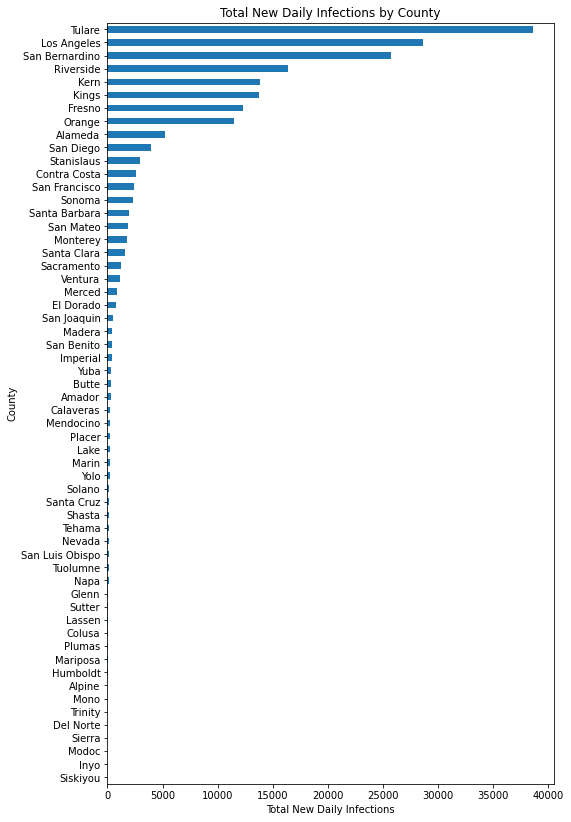

In [11]:
# Visualize which counties have the most total number of
# new daily infections over the entire time period.

plt.figure(figsize=(8,14))
msph.groupby(['county'])['est_new_infections'].sum().sort_values().plot.barh()
plt.title('Total New Daily Infections by County')
plt.xlabel('Total New Daily Infections')
plt.ylabel('County');

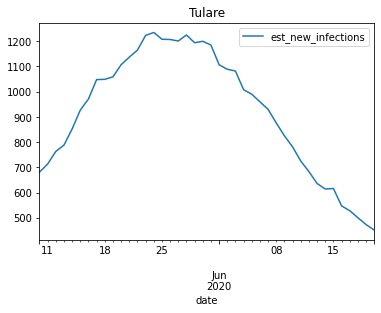

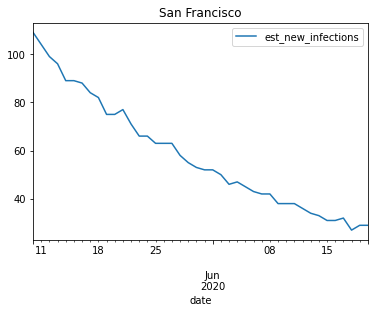

In [12]:
# Plot the daily infections for a couple counties

tulare = msph.loc[msph['county'] == 'Tulare']
sf = msph.loc[msph['county'] == 'San Francisco']

tulare.plot(x='date', y='est_new_infections', title="Tulare")
sf.plot(x='date', y='est_new_infections', title ="San Francisco");

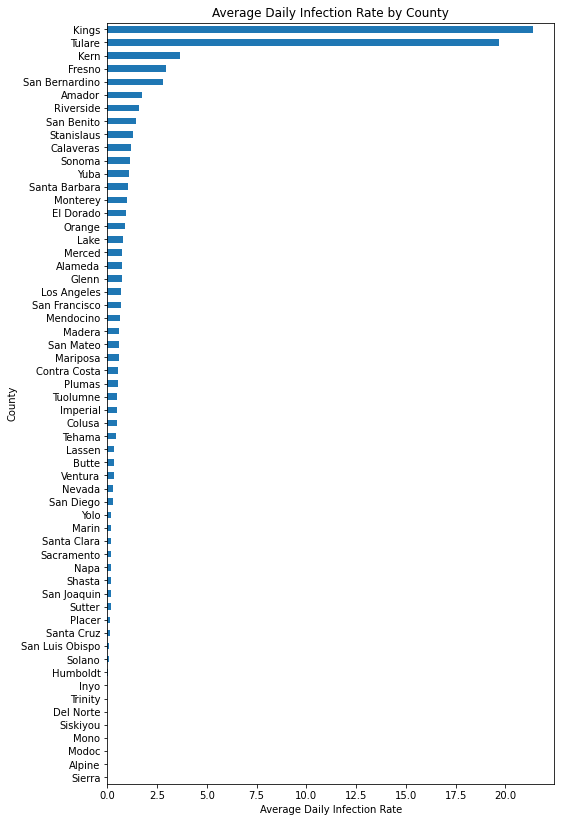

In [12]:
# Visualize which counties have the highest average
# daily infection rate over the entire time period.

plt.figure(figsize=(8,14))
msph.groupby(['county'])['daily_infection_rate'].mean().sort_values().plot.barh()
plt.title('Average Daily Infection Rate by County')
plt.xlabel('Average Daily Infection Rate')
plt.ylabel('County');

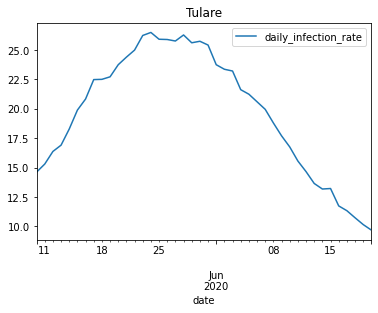

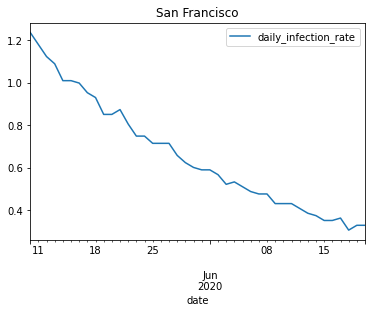

In [13]:
# Plot the daily infection rate for a couple counties

tulare = msph.loc[msph['county'] == 'Tulare']
sf = msph.loc[msph['county'] == 'San Francisco']

tulare.plot(x='date', y='daily_infection_rate', title="Tulare")
sf.plot(x='date', y='daily_infection_rate', title ="San Francisco");

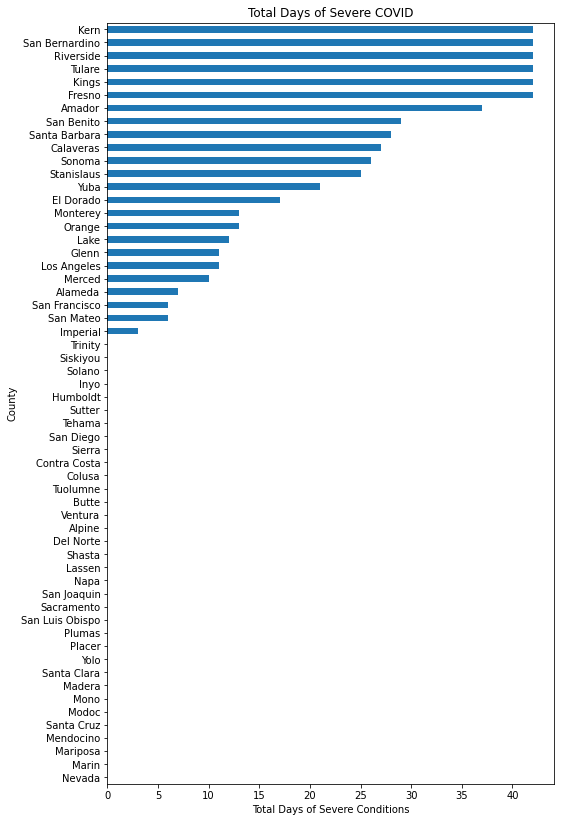

In [14]:
# Visualize the counties with the most days of severe conditions

plt.figure(figsize=(8,14))
msph.groupby(['county'])['severe'].sum().sort_values().plot.barh()
plt.title('Total Days of Severe COVID')
plt.xlabel('Total Days of Severe Conditions')
plt.ylabel('County');

In [15]:
# Export the dataframe to csv file

msph.to_csv('./Cleaned_Data/COVID_proj_CA_511.csv', index=False)